---

title: "理解 Kernel Density Estimation"
date: 2025-04-16
author: 郝鸿涛
slug: kde
draft: false
toc: true
tags: ML
---

{{<block class="note">}}

Matthew Conlen [用一篇动态可视化](https://mathisonian.github.io/kde/)很好地解释了 KDE，值得参考。
{{<end>}}

## 缘起

KDE 是一个很重要的概念。它在数据真实的底层分布不确定并且很可能没有一个标准分布 (比如正态分布) 时特别有用。

拿[高斯混合分布](/cn/2024/11/21/gmm/) 里用到的数据来举例：

In [72]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
import json

np.random.seed(42)

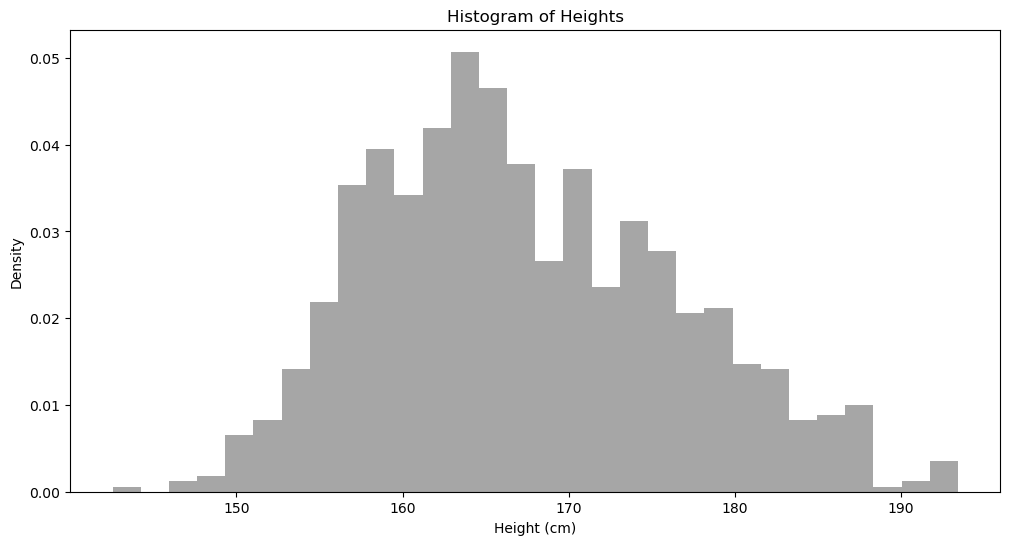

In [73]:
#|code-fold:true

n_female = 600
mu_female = 162
sd_female = 6
n_male = 1000 - n_female
mu_male = 175
sd_male = 7

female_heights = np.random.normal(mu_female, sd_female, n_female)
male_heights = np.random.normal(mu_male, sd_male, n_male)
heights = np.concatenate([female_heights, male_heights])
np.random.shuffle(heights)

plt.figure(figsize=(12, 6))
plt.hist(heights, bins = 30, density=True, alpha=0.7, color='gray')
plt.title('Histogram of Heights')
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.show()

有了这个直方图，我们已经可以做很多事情，比如我们大概知道我们随机挑一个人，此人身高为 170 的可能性要小于身高 164。但这种估计非常不精确，而且需要用肉眼看。如果在大规模运算时，我们根本不可能让计算机每算一个数据的可能性都看一下这个直方图。怎么办？

我们需要一个精确计算任意一点 (Evaluation Point) 概率密度的方法。

首先，身高是一个连续变量，也就是身高可以是 1.71，也可以是 1.72 等等。所以，我们比较 170 与 164 的可能性时，我们肯定不能说直接看它们各自的频率。

一个非常简单的解决办法是，我们把 170 与 164 周边的点考虑进去，比如，我们比一下身高在 169-171 以及 163-165 的密度。但一个问题是，「周边」的点，那到底范围是多大？

这是一个非常经典的问题。这个范围叫做「带宽 (bandwidth)」。

带宽的选择有很多种方法，我们看 scott：

$$h = \sigma \cdot n^{1/5}$$

其中 $h$ 是带宽的计算结果，$\sigma$ 是所有数据的标准差，$n$ 是数据点数量。需要注意的是，$\sigma$ 这里是把所有数据当成总体，而不是样本，所以不需要用 [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction)。

In [74]:
sigma = np.std(heights)
n = len(heights)
h = sigma * n ** (-0.2)
print(f"带宽为: {h}")

带宽为: 2.297198497058672


好，有了这个带宽，一个非常直接的方法是，我们比较一下，数据点落在 $x \pm h$ 的频率。$x$ 是一个评估点，比如 170、164。

In [75]:
x_170_freq = sum(170 - h <= height <= 170 + h for height in heights)
x_164_freq = sum(164 - h <= height <= 164 + h for height in heights)
print(f"身高落在 170cm 附近的频率是 {x_170_freq}；落在 164cm 附近的频率是 {x_164_freq}")

身高落在 170cm 附近的频率是 145；落在 164cm 附近的频率是 218


## 概率密度函数

如果我们只是想比较两个数据点哪个更可能在数据中出现，那我们目前的比较两者附近频率的方法是可行的。但很多时候，我们需要知道，给定一个数据点 $x$，它在我们上面的那个分布中的概率密度具体是多少，也就是说，我们想知道一个具体的概率密度函数 (PDF)： $\hat{f}_h (x)$。

我举几个例子：

- 你想知道哪个身高最可能出现。你当然可以用肉眼看，然后得出大概是 164cm 的结果。你当然可以把所有数据扔给电脑让它找出频率最高的那个身高，但是这么做的问题是，最可能出现的身高一定是一个具体的已经出现的身高。而如果我们有一个具体的 PDF 的话，就可以找到一个不一定已经出现的数据点。
- 生成新样本：这个用频率比较的方法完全不行。
- 比较模型性能。一个最简单的例子，带宽的计算方法有很多种，但哪一个最适合于我们的数据？每一种带宽的选择都对应着不同的 PDF，那最简单的方法是，我给几个新的样本，我计算一下这几个新样本的概率密度，哪个模型能让这概率密度之积越大，那这个模型越好，因为这意味着这个模型让新样本出现的可能性最大。当然，在具体的计算中，我们不计算乘积，而是计算 Log Likelihood 之和。

好，我们现在知道了得出概率密度函数 $\hat{f}_h (x)$ 的重要性，但是如何得到？数学家早就给出了答案：

$$\hat{f}_h (x) = \frac{1}{nh}\sum_{i=1}^n K\left( \frac{x - x_i}{h} \right) \tag{1}$$

这里

- $n$ 是数据点数量。
- $h$ 是带宽。
- $x$ 是待评估的点 (Evaluation Point)。
- $x_i$ 是已有数据中的其中一个具体的数值。
- $K$ 是和核密度函数 (Kernel Density Function)，这个我们下面会讲。

在讲核密度函数之前，我们先来证明一下

$$\begin{aligned} 
    \int_{-\infty}^\infty \hat{f}_h (x) dx &
    = \int \frac{1}{nh}\sum_{i=1}^n K\left( \frac{x - x_i}{h} \right)dx \\ &
    = \frac{1}{nh}\sum_{i=1}^n \int K\left( \frac{x - x_i}{h} \right)dx \\ &
    = \frac{1}{nh}\sum_{i=1}^n \int K(u)\cdot h \cdot du \\ &
    = \frac{1}{n}\sum_{i=1}^n \int K(u)\cdot du  \\& 
    = \frac{1}{n}\sum_{i=1}^n \\&
    = 1
\end{aligned}$$

这里面用到的点：

首先，既然 $K$ 是核密度函数，那必然的，$\int K(u)du = 1$。

中间的换元：

另 $u = \frac{x - x_i}{h}$，我们有 $x = uh + x_i$，然后对 $x$ 关于 $u$ 求导 （当 $u$ 增加一点点，$x$ 会有什么变化）：

$$\frac{dx}{du} = \frac{d}{du}(hu + x_i) = h \Rightarrow dx = h \cdot du$$

## 高斯核

高斯核是 KDE 里非常常用的一种核密度函数。

我们回想一下，高斯分布的概率密度函数是：

$$f(x) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2}$$

令

$$u = \frac{x - x_i}{h}$$

常用的核密度函数是

$$K(u) = \frac{1}{\sqrt{2 \pi}}e^{- \frac{u^2}{2}}$$

对比一下你就知道，这是 $\mathcal{N}(0,1)$ 的 PDF。

一般的统计教材都不会讲这么细。但即使讲到这里，好奇的你可能还有一个疑问，用 $u = \frac{x - x_i}{h}$ 换元确实让表达式看起来更加整洁，但是我们一下子不知道整个概率密度函数 $\hat{f}_h (x)$ 和 $x$ 有什么关系了。


我们用 $x$ 表示：

$$K_h(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2}$$

和标准正态分布的密度函数对比一下我们发现，如果把 $\sqrt{2\pi}$ 变成 $\sqrt{2\pi h^2}$，那 $K_h(x)$ 就是 $\mathcal{N}(x_i, h^2)$ 的概率密度函数。但问题是，$h^2$ 并没有在公式里面啊！

其实，回到公式 (1)，如果我们把 $\frac{1}{h}$ 去掉：

$$\hat{f}_h (x) = \frac{1}{n}\sum_{i=1}^n K_i(x)$$

然后让核密度函数为：

$$K_i(x) = \frac{1}{\sqrt{2\pi h^2}} e^{-\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2}$$

一切就都说得通了，而且更加直观。

怎么理解：对于任何一个新的数据 $x$，我们想计算其概率密度。怎么计算呢？我们找到原始数据，也就是 `heights` 的每一个点 $x_i$，然后计算 $x$ 在 $\mathcal{N}(x_i, h^2)$ 的概率密度。然后把所有这些概率密度加起来，就是新数据点 $x$ 在这个未知分布中的概率密度了。

## 总结

总结一下，公式 (1) 可以写成

$$\hat{f}_h (x) = \frac{1}{nh}\sum_{i=1}^n K(u) \tag{1}$$

其中

- $u =  \frac{x - x_i}{h}$。
- $K(u) = \frac{1}{\sqrt{2 \pi}}e^{- \frac{u^2}{2}}$，表示 $\mathcal{N}(0,1)$ 的概率密度函数。

公式 (1) 也可以写成：

$$\hat{f}_h (x) = \frac{1}{n}\sum_{i=1}^n K_i(x) \tag{2}$$

其中

$$K_i(x) = \frac{1}{\sqrt{2\pi h^2}} e^{-\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2}$$

表示 $\mathcal{N}(x_i, h^2)$ 的概率密度函数。

这两种表达方式都可以的。大家比较倾向于第一种，因为它明确表示了 $h$ 是不变的。第二个公式里 $h$ 是被藏在 $K_i(x)$ 里，不太明显。

## 计算

下面，我们具体计算一下。

KDE 的另一个非常有用的地方是可视化：我们可以用连续的方法画出底层可能的分布，而不是单纯用直方图。

怎么画呢？既然 $\hat{f}_h (x)$ 可以给我们数据点 $x$ 在分布中的具体概率密度，那我们从上面分布中的最低身高到最高身高，找 1000 个点，算出每个点的概率密度，然后连起来，不就是 KDE 曲线了吗？

In [76]:
min(heights), max(heights)

(142.55239595958557, 193.42667445386172)

In [77]:
import math 
from numba import njit 

SQRT_2PI = math.sqrt(2.0 * math.pi)

@njit(fastmath=True)
def gaussian_kernel(x: float, xi: float, bw: float) -> float:
    """ calculate K_i(x)
    """
    z = (x - xi) / bw
    return math.exp(-0.5 * z * z) / (bw * SQRT_2PI)

@njit(fastmath=True)
def calculate_bandwidth(data: np.ndarray, scale:float=1.0) -> float:
    n = len(data)
    sigma = max(np.std(data), 1e-12)
    return sigma * n ** (-0.2) * scale

@njit(fastmath=True)
def _compute_pdf(x: float, data: np.ndarray, bw: float) -> float:
    """Compute PDF of an evaluation point (x)
    """
    pdf = 0.0 
    for j in range(len(data)):
        pdf += gaussian_kernel(x, data[j], bw)
    return pdf/len(data)

def obtain_densities(xs: np.ndarray, data: np.ndarray, bw_scale: float = 1.0) -> np.ndarray:
    densities = np.zeros(len(xs))
    bw = calculate_bandwidth(data, scale = bw_scale)
    for idx, x in enumerate(xs):
        densities[idx] = _compute_pdf(x, data, bw)
    return densities 

Bandwidth used: 2.30
Number of data points: 1000
Mean height: 167.34 cm
Standard deviation: 9.15 cm


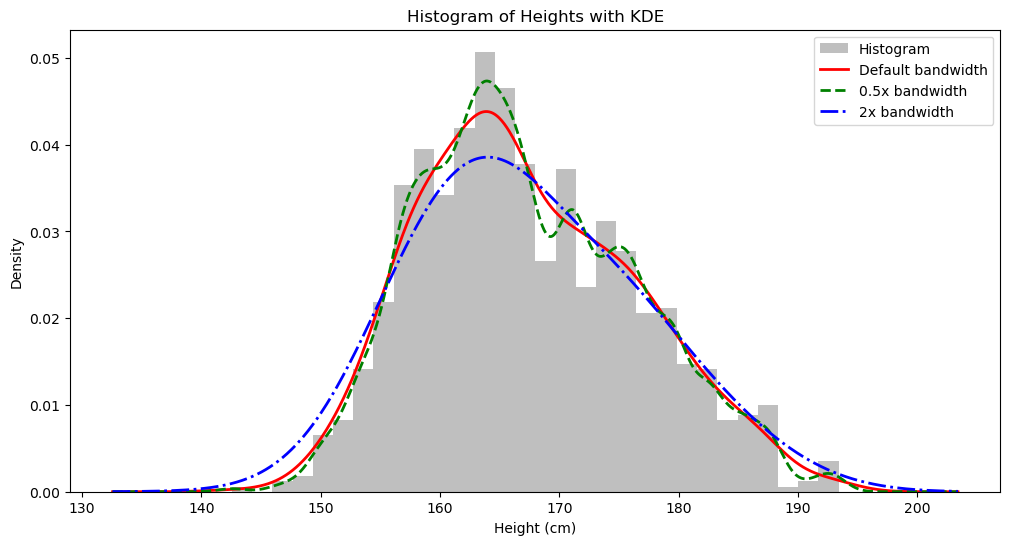

In [78]:
#| code-fold: true

# Create evaluation points for KDE
x_min = min(heights) - 10
x_max = max(heights) + 10
x_eval = np.linspace(x_min, x_max, 1000)

# Compute KDE
densities = obtain_densities(x_eval, heights)
densities_half_bw_scale = obtain_densities(x_eval, heights, bw_scale = 0.5)
densities_double_bw_scale = obtain_densities(x_eval, heights, bw_scale = 2)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram
plt.hist(heights, bins=30, density=True, alpha=0.5, color='gray', label='Histogram')

# Plot KDE
plt.plot(x_eval, densities, 'r-', linewidth=2, label='Default bandwidth')

plt.plot(x_eval, densities_half_bw_scale, 'g--', linewidth=2, label='0.5x bandwidth')

plt.plot(x_eval, densities_double_bw_scale, 'b-.', linewidth=2, label='2x bandwidth')

# Add labels and legend
plt.title('Histogram of Heights with KDE')
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.legend()

# Optional: show statistics
bw = calculate_bandwidth(heights)
print(f"Bandwidth used: {bw:.2f}")
print(f"Number of data points: {len(heights)}")
print(f"Mean height: {np.mean(heights):.2f} cm")
print(f"Standard deviation: {np.std(heights):.2f} cm")

# Show plot
plt.show()

我们用 Scipy 来计算并可视化一下：

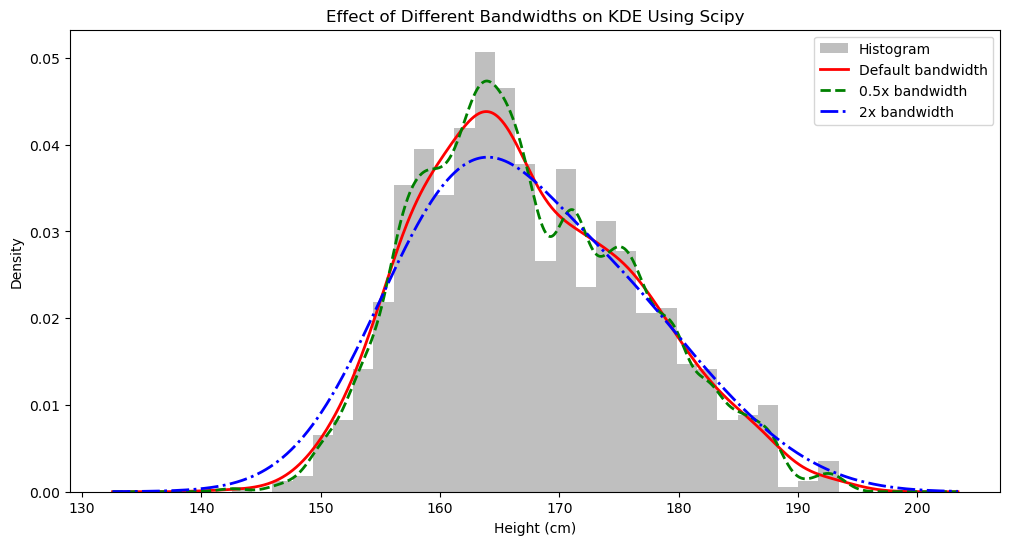

In [79]:
#|code-fold:true

# Optional: Compare bandwidths
# Calculate the bandwidth that scipy uses
bw_scipy = kde.factor * np.std(heights) * (len(heights) ** (-1/5))
# print(f"Scipy bandwidth: {bw_scipy:.2f}")

# Explicitly compare different bandwidths (optional)
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=30, density=True, alpha=0.5, color='gray', label='Histogram')

# Default bandwidth
kde1 = stats.gaussian_kde(heights)
plt.plot(x_eval, kde1(x_eval), 'r-', linewidth=2, label='Default bandwidth')

# Custom bandwidth (0.5x default)
kde2 = stats.gaussian_kde(heights, bw_method=kde.factor * 0.5)
plt.plot(x_eval, kde2(x_eval), 'g--', linewidth=2, label='0.5x bandwidth')

# Custom bandwidth (2x default)
kde3 = stats.gaussian_kde(heights, bw_method=kde.factor * 2)
plt.plot(x_eval, kde3(x_eval), 'b-.', linewidth=2, label='2x bandwidth')

plt.title('Effect of Different Bandwidths on KDE Using Scipy')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.legend()
plt.show()

我们看到我们自己定义的方法是正确的，因为结果一样。

## 加权 KDE 

有时候，原始数据中的每一个数据点都有相应的权重 (weight)。比如，身高 170 cm，属于男生的概率是 0.8，属于女生的概率是 0.2。有权重时，带宽和 $\hat{f}_h (x)$ 的计算方法都会有相应的变化。

有权重时，Scott 带宽计算方法为：

$$h = \sigma_w \cdot n_\text{eff}^{-1/5}$$

设每个数据点 $x_i$ 对应的权重为 $w_i$，我们有:

$$\mu_w = \frac{\sum w_i x_i}{\sum w_i}$$

$$\sigma_w^2 = \frac{\sum w_i (x_i - \mu_w)^2}{\sum w_i}$$

$$n_\text{eff} = \frac{1}{\sum w_i^2}$$

相应的，概率密度函数也变为：

$$\hat{f}_h (x) = \sum_{i=1}^n w_i \frac{1}{\sqrt{2\pi h^2}} e^{-\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2} \tag{3}$$

需要注意的是，$w$ 必须进行归一化处理，即 $\sum_{i=1}^n w_i = 1$，如果不确定，那加权 KDE 的概率密度函数更严谨的表述方式是：

$$\hat{f}_h (x) = \frac{\sum_{i=1}^n w_i \frac{1}{\sqrt{2\pi h^2}} e^{-\frac{1}{2} \left( \frac{x - x_i}{h} \right)^2}}{\sum_{i=1}^n w_i} \tag{4}$$